In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model as lm
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
pip install bootstrapped

Note: you may need to restart the kernel to use updated packages.


In [4]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [5]:
letters_train = pd.read_csv('Letters_train.csv')
letters_test = pd.read_csv('Letters_test.csv')

## a.i)

In [6]:
letters_train['isB'] = ['Yes' if letters_train['letter'][i]=='B' else 'No' for i in range(len(letters_train))]
letters_test['isB'] = ['Yes' if letters_test['letter'][i]=='B' else 'No' for i in range(len(letters_test))]

In [7]:
letters_train.head()

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor,isB
0,B,2,6,4,4,3,8,8,5,7,7,6,6,2,8,6,9,Yes
1,R,4,8,5,6,4,7,8,6,5,7,6,8,3,7,6,9,No
2,B,4,8,6,6,7,8,7,6,3,7,8,7,6,10,8,9,Yes
3,A,5,6,7,5,5,8,8,3,5,7,9,8,5,9,4,6,No
4,B,2,5,5,3,3,9,6,3,6,10,4,7,4,7,6,9,Yes


In [8]:
baseline_preds = []
for i in range(len(letters_test)):
    baseline_preds.append('No')

baseline_acc = accuracy_score(letters_test['isB'], baseline_preds)
print('Baseline Accuracy :', baseline_acc)

Baseline Accuracy : 0.746524064171123


## a.ii)

In [9]:
letters_train_ohe_all = pd.get_dummies(letters_train, drop_first = True)
letters_train_ohe_all = letters_train_ohe_all.rename(columns = {'isB_Yes':'isB'})

letters_test_ohe_all = pd.get_dummies(letters_test, drop_first = True)
letters_test_ohe_all = letters_test_ohe_all.rename(columns = {'isB_Yes':'isB'})

letters_train_ohe = letters_train_ohe_all.drop(columns = {'letter_B', 'letter_P', 'letter_R'})
letters_test_ohe = letters_test_ohe_all.drop(columns = {'letter_B', 'letter_P', 'letter_R'})

In [10]:
log_mod = smf.logit(formula = 'isB ~ xbox + ybox + width + height + onpix + xbar + \
                                     ybar + x2bar + y2bar + xybar + x2ybar + xy2bar + \
                                     xedge + xedgeycor + yedge + yedgexcor', data = letters_train_ohe).fit()
log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.155134
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    isB   No. Observations:                 2181
Model:                          Logit   Df Residuals:                     2164
Method:                           MLE   Df Model:                           16
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                  0.7200
Time:                        20:31:47   Log-Likelihood:                -338.35
converged:                       True   LL-Null:                       -1208.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.5595      2.303     -5.888      0.000     -18.073      -9.046
xbox           0.0835      0.119      0.702      0.482      -0.149       0.316
ybox           0.0469      0.082      0.573      0.567      -0.113       0.207
width         -1.3216      0.153     -8.621      0.000      -1.622      -1.021
height        -0.6980      0.128     -5.433      0.000      -0.950      -0.446
onpix          0.9792      0.130      7.515      0.000       0.724       1.235
xbar           0.6668      0.119      5.601      0.000       0.433       0.900
ybar          -0.5639      0.109     -5.158      0.000      -0.778      -0.350
x2bar         -0.4077      0.092     -4.425      0.000      -0.588      -0.227
y2bar          1.3047      0.120     10.910      0.000       1.070       1.539
xybar          0.1775      0.087      2.049      0.040       0.008       0.347
x2ybar         0.4156      0.113      3.684      0.000       0.195       0.637
xy2bar        -0.5295      0.108     -4.924      0.000      -0.740      -0.319
xedge         -0.2515      0.089     -2.815      0.005      -0.427      -0.076
xedgeycor      0.1020      0.100      1.020      0.308      -0.094       0.298
yedge          1.7501      0.129     13.529      0.000       1.497       2.004
yedgexcor      0.3695      0.070      5.242      0.000       0.231       0.508
==============================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [11]:
log_mod_pred_raw = log_mod.predict(letters_test_ohe)
log_mod_pred = pd.Series([1 if x > 0.5 else 0 for x in log_mod_pred_raw])

log_cm = confusion_matrix(letters_test_ohe['isB'], log_mod_pred)
log_accuracy = (log_cm.ravel()[0] + log_cm.ravel()[3]) / sum(log_cm.ravel())
print('Logistic Model Accuracy :', log_accuracy)

Logistic Model Accuracy : 0.9411764705882353


## a.iii)

In [12]:
fpr, tpr, _ = roc_curve(letters_test_ohe['isB'], log_mod_pred)
log_auc = metrics.auc(fpr, tpr)
print('auc :', log_auc)

auc : 0.9271607848826665


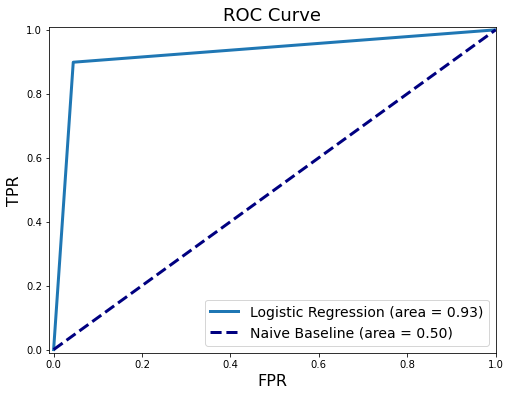

In [13]:
plt.figure(figsize=(8,6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-.01, 1.00])
plt.ylim([-.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(log_auc))
plt.plot([0,1], [0,1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## a.iv)

In [14]:
x_train = letters_train_ohe.drop(columns = {'isB'})
x_test = letters_test_ohe.drop(columns = {'isB'})

y_train = letters_train_ohe['isB']
y_test = letters_test_ohe['isB']

In [15]:
dec_tree_mod = DecisionTreeClassifier()
grid_values = {'ccp_alpha': np.linspace(0, 0.010, 201),
              'min_samples_leaf': [5],
              'min_samples_split': [20],
              'max_depth': [30],
              'random_state': [42]}
dec_tree_cv = GridSearchCV(dec_tree_mod, param_grid = grid_values, scoring = 'accuracy', cv = 10, verbose = 0)
dec_tree_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.00e+00, 5.00e-05, 1.00e-04, 1.50e-04, 2.00e-04, 2.50e-04,
       3.00e-04, 3.50e-04, 4.00e-04, 4.50e-04, 5.00e-04, 5.50e-04,
       6.00e-04, 6.50e-04, 7.00e-04, 7.50e-04, 8.00e-04, 8.50e-04,
       9.00e-04, 9.50e-04, 1.00e-03, 1.05e-03, 1.10e-03, 1.15e-03,
       1.20e-03, 1.25e-03, 1.30e-03, 1.35e-03, 1.40e-03, 1.45...
       8.70e-03, 8.75e-03, 8.80e-03, 8.85e-03, 8.90e-03, 8.95e-03,
       9.00e-03, 9.05e-03, 9.10e-03, 9.15e-03, 9.20e-03, 9.25e-03,
       9.30e-03, 9.35e-03, 9.40e-03, 9.45e-03, 9.50e-03, 9.55e-03,
       9.60e-03, 9.65e-03, 9.70e-03, 9.75e-03, 9.80e-03, 9.85e-03,
       9.90e-03, 9.95e-03, 1.00e-02]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [42]},
             scoring='accuracy')

In [16]:
acc = dec_tree_cv.cv_results_['mean_test_score']
ccp = dec_tree_cv.cv_results_['param_ccp_alpha'].data

alpha_vals = pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy' : acc})
alpha_vals

,ccp alpha,Validation Accuracy
0,0.0,0.933057
1,0.00005,0.933057
2,0.0001,0.933057
3,0.00015,0.933057
4,0.0002,0.933057
...,...,...
196,0.0098,0.882604
197,0.00985,0.882604
198,0.0099,0.882146
199,0.00995,0.881228


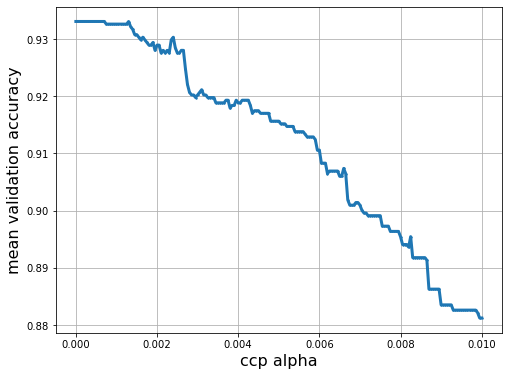

In [17]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [18]:
print('Best Alpha Value:', dec_tree_cv.best_params_['ccp_alpha'])
print('Best Mean Validation Accuracy:', dec_tree_cv.best_score_)

Best Alpha Value: 0.0
Best Mean Validation Accuracy: 0.9330568472204768


In [19]:
alpha_vals[alpha_vals['Validation Accuracy'] == dec_tree_cv.best_score_]

,ccp alpha,Validation Accuracy
0,0.0,0.933057
1,0.00005,0.933057
2,0.0001,0.933057
3,0.00015,0.933057
4,0.0002,0.933057
5,0.00025,0.933057
6,0.0003,0.933057
7,0.00035,0.933057
8,0.0004,0.933057
9,0.00045,0.933057


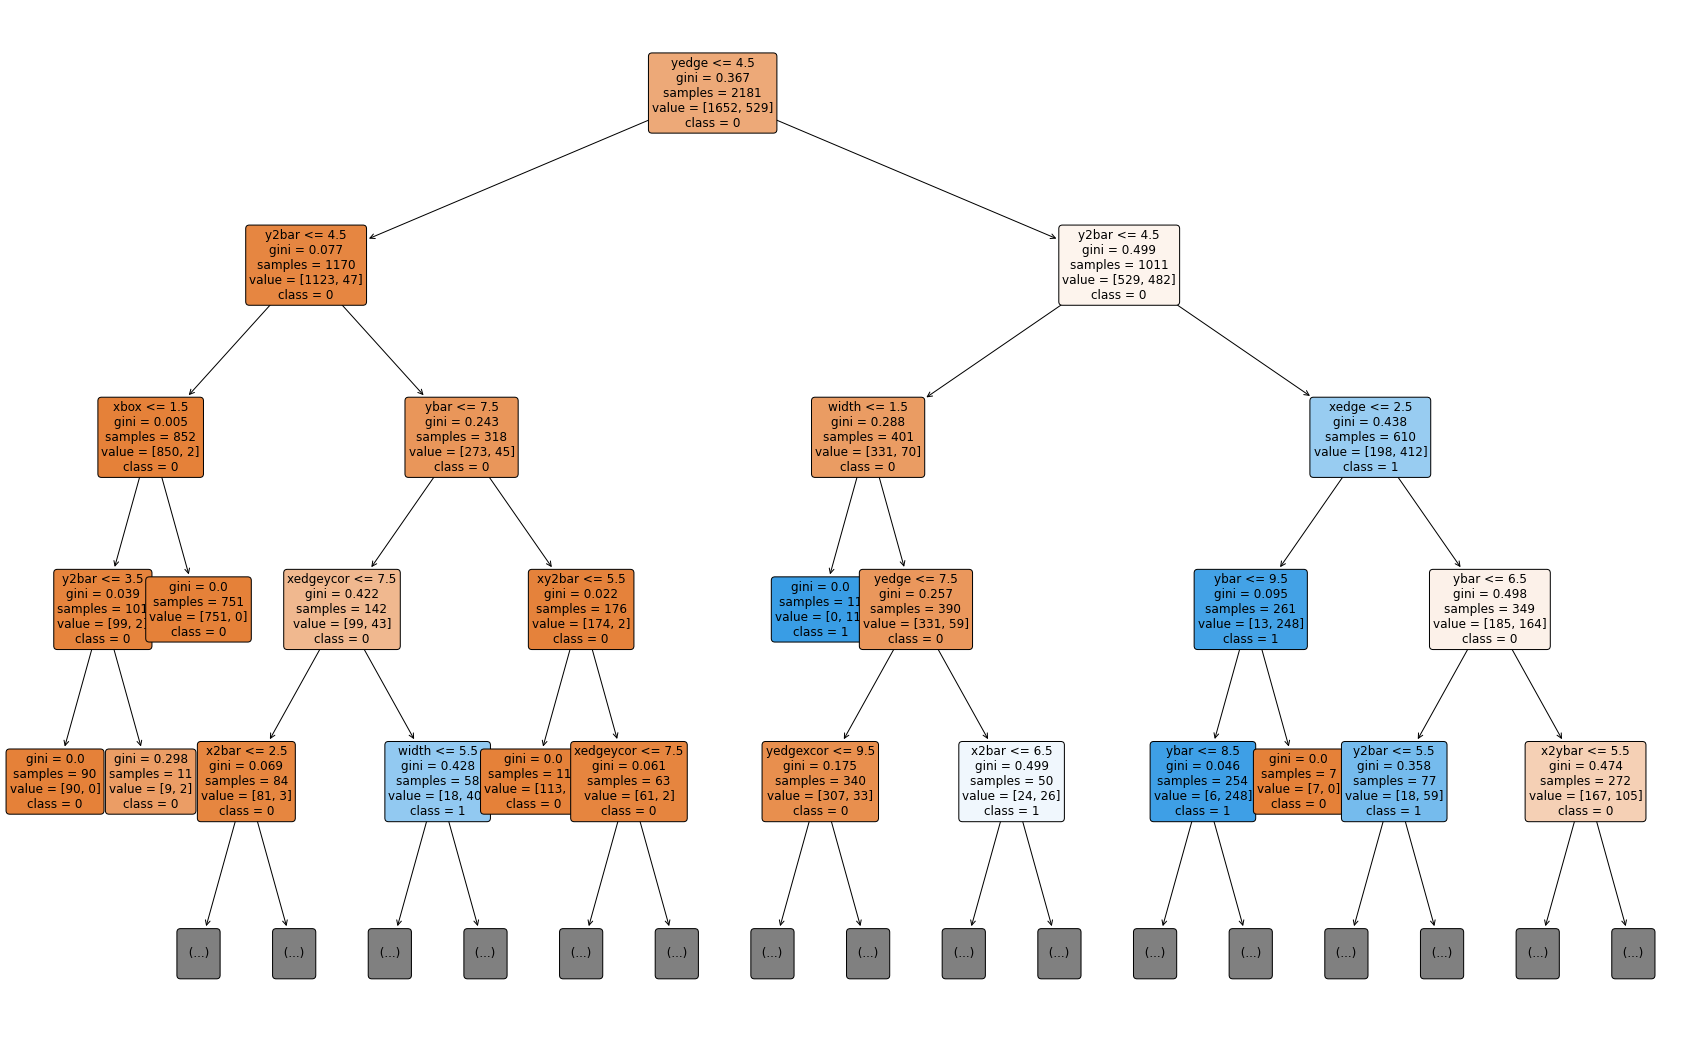

In [20]:
plt.figure(figsize=(30,19));
plot_tree(dec_tree_cv.best_estimator_, 
          feature_names=x_train.columns, 
          class_names=['0','1'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=4);

In [21]:
dec_tree_pred = dec_tree_cv.best_estimator_.predict(x_test)
tree_cm = confusion_matrix(y_test, dec_tree_pred)
tree_accuracy = (tree_cm.ravel()[0] + tree_cm.ravel()[3]) / sum(tree_cm.ravel())
print('CART Model Accuracy :', tree_accuracy)

CART Model Accuracy : 0.9347593582887701


## a.v)

In [22]:
rf = RandomForestClassifier(#max_features = 5,
                          #min_samples_leaf = 5,
                          #n_estimators = 500,
                          random_state = 42,
                          verbose = 0)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
random_forest_pred = rf.predict(x_test)

rf_cm = confusion_matrix(y_test, random_forest_pred)
rf_accuracy = (rf_cm.ravel()[0] + rf_cm.ravel()[3]) / sum(rf_cm.ravel())
print('Random Forest Accuracy :', rf_accuracy)

Random Forest Accuracy : 0.9828877005347594


## a.vi)

In [24]:
a_accuracy_data = {'logistic_model_accuracy':log_accuracy, 'CART_accuracy':tree_accuracy, 'random_forest_accuracy':rf_accuracy}
a_accuracy_data

{'logistic_model_accuracy': 0.9411764705882353,
 'CART_accuracy': 0.9347593582887701,
 'random_forest_accuracy': 0.9828877005347594}

## b.i)

In [25]:
letters_train = pd.read_csv('Letters_train.csv')
letters_test = pd.read_csv('Letters_test.csv')

In [26]:
# predict "P" for baseline model
letters_train.groupby('letter').size()

letter
A    562
B    529
P    578
R    512
dtype: int64

In [27]:
letters_test.groupby('letter').size()

letter
A    227
B    237
P    225
R    246
dtype: int64

In [28]:
multi_class_baseline_accuracy = 225 / (227 + 237 + 225 + 246)
print('Baseline Accuracy :', multi_class_baseline_accuracy)

Baseline Accuracy : 0.24064171122994651


## b.ii)

In [29]:
x_train_lda = letters_train.drop(columns = {'letter'})
x_test_lda = letters_test.drop(columns = {'letter'})

y_train_lda = letters_train['letter']
y_test_lda = letters_test['letter']

In [30]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_lda, y_train_lda)
lda_predictions = lda.predict(x_test_lda)
lda_accuracy = sum(y_test_lda == lda_predictions)/len(y_test_lda)
print('LDA Model Accuracy :', lda_accuracy)

LDA Model Accuracy : 0.9005347593582887


## b.iii)

In [31]:
dec_tree_mod_lda = DecisionTreeClassifier()
grid_values_lda = {'ccp_alpha': np.linspace(0, 0.010, 201),
              'min_samples_leaf': [5],
              'min_samples_split': [20],
              'max_depth': [30],
              'random_state': [42]}
dec_tree_cv_lda = GridSearchCV(dec_tree_mod_lda, param_grid = grid_values_lda, scoring = 'accuracy', cv = 10, verbose = 0)
dec_tree_cv_lda.fit(x_train_lda, y_train_lda)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.00e+00, 5.00e-05, 1.00e-04, 1.50e-04, 2.00e-04, 2.50e-04,
       3.00e-04, 3.50e-04, 4.00e-04, 4.50e-04, 5.00e-04, 5.50e-04,
       6.00e-04, 6.50e-04, 7.00e-04, 7.50e-04, 8.00e-04, 8.50e-04,
       9.00e-04, 9.50e-04, 1.00e-03, 1.05e-03, 1.10e-03, 1.15e-03,
       1.20e-03, 1.25e-03, 1.30e-03, 1.35e-03, 1.40e-03, 1.45...
       8.70e-03, 8.75e-03, 8.80e-03, 8.85e-03, 8.90e-03, 8.95e-03,
       9.00e-03, 9.05e-03, 9.10e-03, 9.15e-03, 9.20e-03, 9.25e-03,
       9.30e-03, 9.35e-03, 9.40e-03, 9.45e-03, 9.50e-03, 9.55e-03,
       9.60e-03, 9.65e-03, 9.70e-03, 9.75e-03, 9.80e-03, 9.85e-03,
       9.90e-03, 9.95e-03, 1.00e-02]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [42]},
             scoring='accuracy')

In [32]:
acc = dec_tree_cv_lda.cv_results_['mean_test_score']
ccp = dec_tree_cv_lda.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy' : acc}).head(5)

,ccp alpha,Validation Accuracy
0,0.0,0.896385
1,0.00005,0.896385
2,0.0001,0.896385
3,0.00015,0.896385
4,0.0002,0.896385


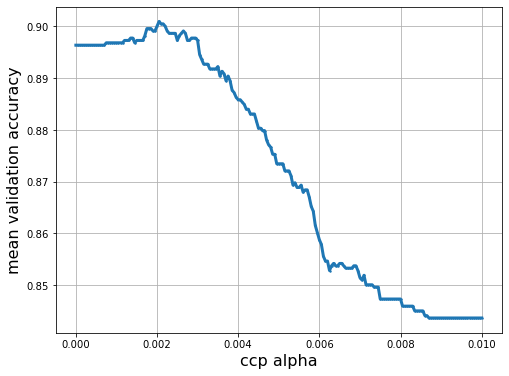

In [33]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [34]:
print('Best Alpha Value:', dec_tree_cv_lda.best_params_['ccp_alpha'])
print('Best Mean Validation Accuracy:', dec_tree_cv_lda.best_score_)

Best Alpha Value: 0.00205
Best Mean Validation Accuracy: 0.900965606803234


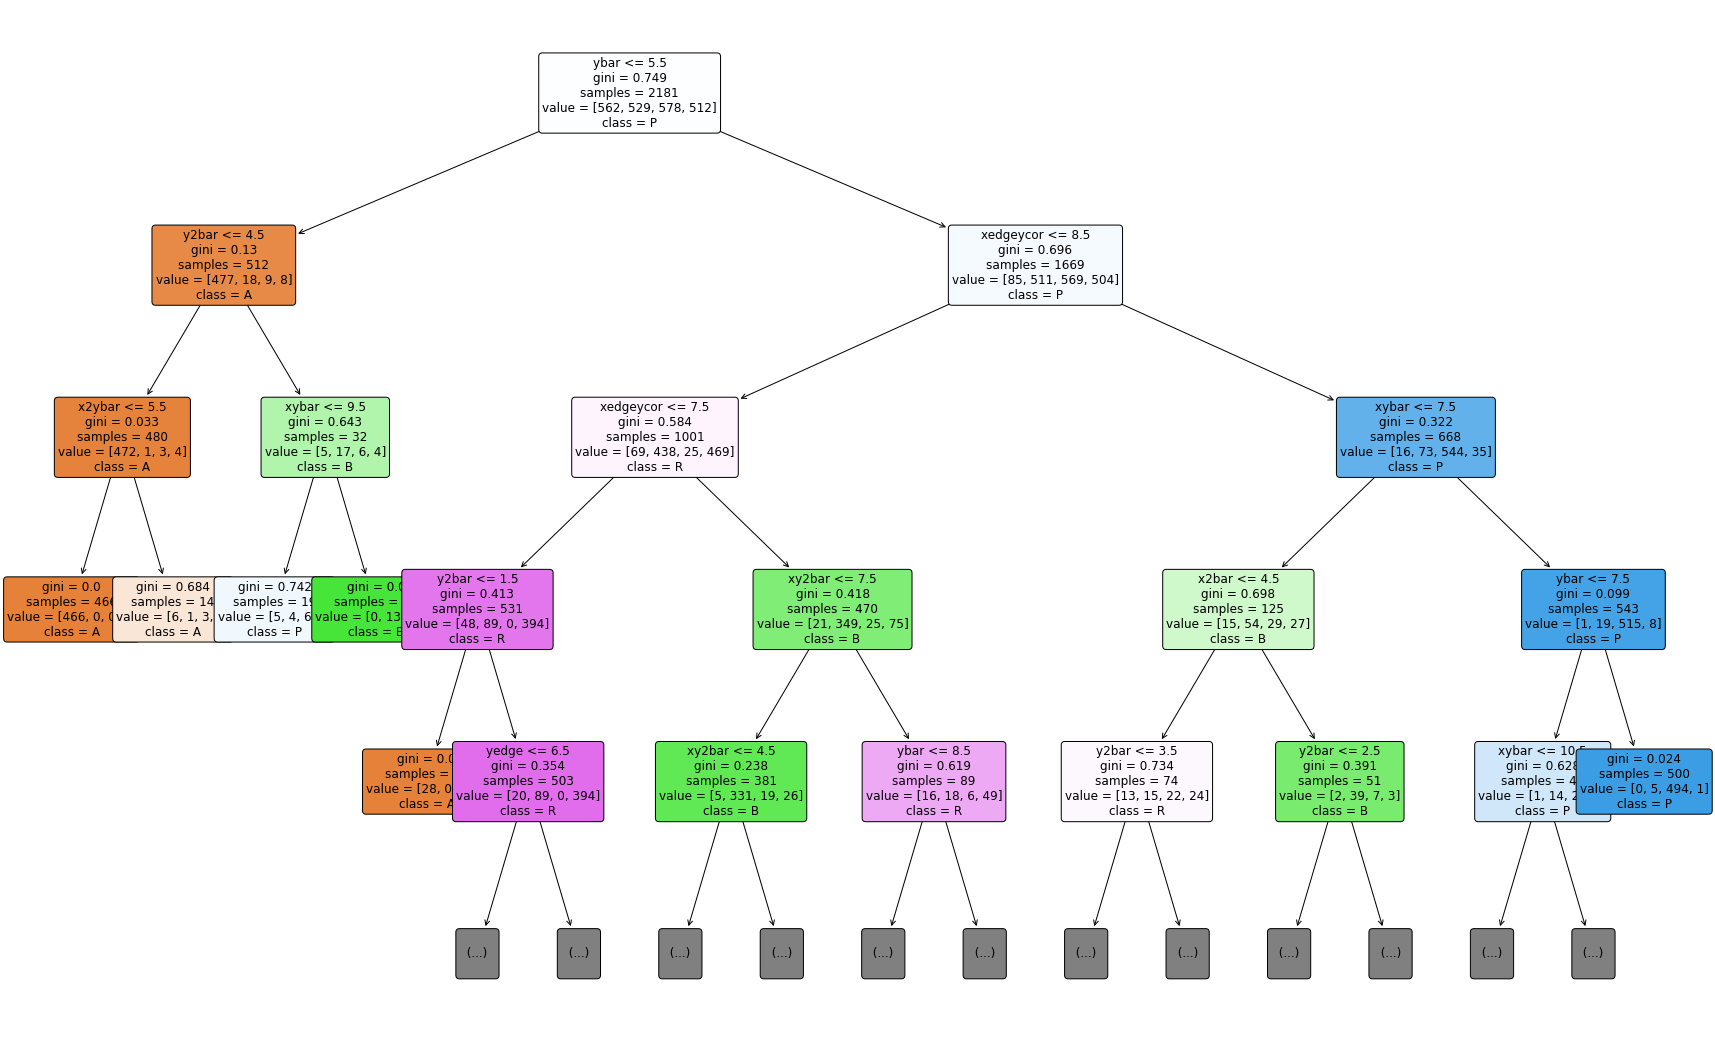

In [35]:
plt.figure(figsize=(30,19));
plot_tree(dec_tree_cv_lda.best_estimator_, 
          feature_names=x_train_lda.columns, 
          class_names=['A','B','P','R'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=4);

In [36]:
dec_tree_pred_lda = dec_tree_cv_lda.best_estimator_.predict(x_test_lda)
cart_accuracy_lda = sum(dec_tree_pred_lda == y_test_lda) / len(y_test_lda)
print('CART Model Accuracy :', cart_accuracy_lda)

CART Model Accuracy : 0.9165775401069519


## b.iv)

In [37]:
rf_lda = RandomForestClassifier(max_features = 16,
                          min_samples_leaf = 5,
                          n_estimators = 500,
                          random_state = 42,
                          verbose = 0)
rf_lda.fit(x_train_lda, y_train_lda)

RandomForestClassifier(max_features=16, min_samples_leaf=5, n_estimators=500,
                       random_state=42)

In [38]:
rf_lda_preds = rf_lda.predict(x_test_lda)
rf_lda_accuracy = sum(rf_lda_preds == y_test_lda) / len(y_test_lda)
print('CART Bagging Model Accuracy :', rf_lda_accuracy)

CART Bagging Model Accuracy : 0.9518716577540107


## b.v)

In [39]:
grid_values_bv = {'max_features': np.linspace(1,16,16, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [42]} 


rf_bv = RandomForestClassifier() 
rf_cv_bv = GridSearchCV(rf_bv, param_grid=grid_values_bv, scoring='accuracy', cv=10,verbose=0)
rf_cv_bv.fit(x_train_lda, y_train_lda)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32),
                         'min_samples_leaf': [5], 'n_estimators': [500],
                         'random_state': [42]},
             scoring='accuracy')

(1.0, 17.0)

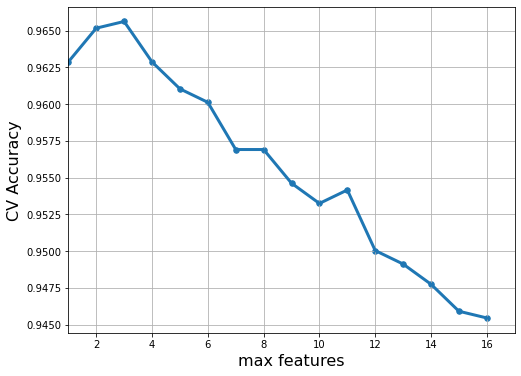

In [40]:
max_features = rf_cv_bv.cv_results_['param_max_features'].data
accuracy_scores = rf_cv_bv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(max_features, accuracy_scores, s=30)
plt.plot(max_features, accuracy_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 17])

In [41]:
acc = rf_cv_bv.cv_results_['mean_test_score']
ccp = rf_cv_bv.cv_results_['param_max_features'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy' : acc}).head(5)

,ccp alpha,Validation Accuracy
0,1,0.962867
1,2,0.965163
2,3,0.965619
3,4,0.962867
4,5,0.961034


In [42]:
rf_cv_bv.best_params_

{'max_features': 3,
 'min_samples_leaf': 5,
 'n_estimators': 500,
 'random_state': 42}

In [43]:
rf_lda_bv = RandomForestClassifier(max_features = rf_cv_bv.best_params_['max_features'],
                          min_samples_leaf = 5,
                          n_estimators = 500,
                          random_state = 42,
                          verbose = 0)
rf_lda_bv.fit(x_train_lda, y_train_lda)

RandomForestClassifier(max_features=3, min_samples_leaf=5, n_estimators=500,
                       random_state=42)

In [44]:
rf_best_features_preds = rf_lda_bv.predict(x_test_lda)
rf_best_features_accuracy = sum(rf_best_features_preds == y_test_lda) / len(y_test_lda)
print('RF Cross Validation Model Accuracy :', rf_best_features_accuracy)

RF Cross Validation Model Accuracy : 0.9625668449197861


## b.vi)

In [45]:
gbr = GradientBoostingClassifier(n_estimators=3300, 
                                 max_leaf_nodes=10,
                                 random_state=42, 
                                 verbose=0) 
gbr.fit(x_train_lda, y_train_lda)

GradientBoostingClassifier(max_leaf_nodes=10, n_estimators=3300,
                           random_state=42)

In [46]:
gbr_predictions = gbr.predict(x_test_lda)
gbr_accuracy = sum(gbr_predictions == y_test_lda) / len(y_test_lda)
print('GBC Model Accuracy :', gbr_accuracy)

GBC Model Accuracy : 0.9700534759358289


## c)

In [47]:
letters_train = pd.read_csv('Letters_train.csv')
letters_test = pd.read_csv('Letters_test.csv')

In [48]:
b_accuracy_data = {'lda_model_accuracy':lda_accuracy, 'CART_accuracy':cart_accuracy_lda, 'bagging_accuracy':rf_lda_accuracy, 'random_forest_accuracy':rf_best_features_accuracy, 'boosting_accuracy':gbr_accuracy}
b_accuracy_data

{'lda_model_accuracy': 0.9005347593582887,
 'CART_accuracy': 0.9165775401069519,
 'bagging_accuracy': 0.9518716577540107,
 'random_forest_accuracy': 0.9625668449197861,
 'boosting_accuracy': 0.9700534759358289}

In [50]:
def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_predicted,bs_label,train_label)
#         if bs_iter % 100 == 0:
#             print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df

In [53]:
def accuracy(predictions, y_test, y_train):
    acc = sum(predictions == y_test) / len(y_test)
    return acc

In [81]:
## LDA Model Bootstrapping
bs_lda_output = bootstrap_validation(x_test_lda, y_test_lda, y_train_lda, lda,
                                 metrics_list=[accuracy],
                                 sample = 5000)

(5000, 1)


(-0.05, 0.05)

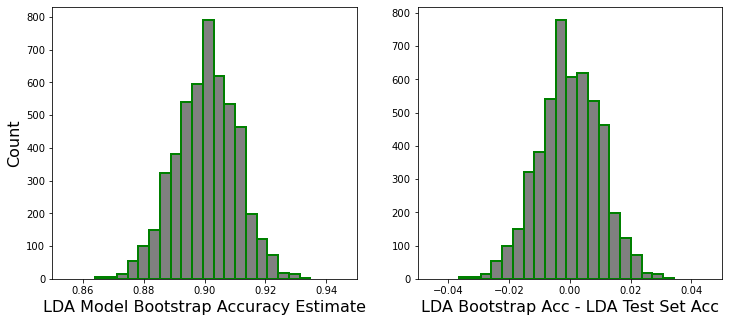

In [82]:
## LDA Model Bootstrapping Graph
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('LDA Model Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('LDA Bootstrap Acc - LDA Test Set Acc', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_lda_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.85,0.95])
axs[1].hist(bs_lda_output.iloc[:,0] - lda_accuracy, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.05,0.05])

In [83]:
## CART Model Bootstrapping
bs_cart_output = bootstrap_validation(x_test_lda, y_test_lda, y_train_lda, dec_tree_cv_lda.best_estimator_,
                                 metrics_list=[accuracy],
                                 sample = 5000)

(5000, 1)


(-0.04, 0.04)

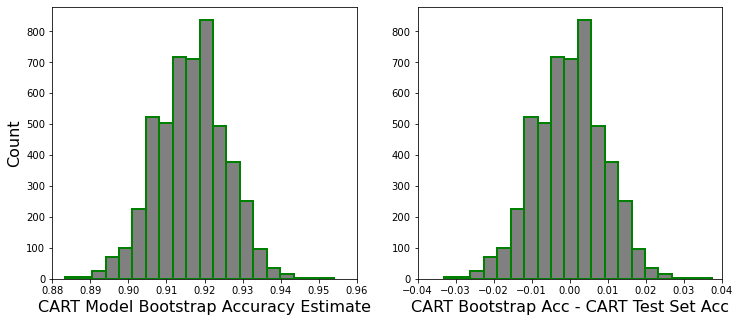

In [88]:
## CART Model Bootstrapping Graph
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('CART Model Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('CART Bootstrap Acc - CART Test Set Acc', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_cart_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.88,0.96])
axs[1].hist(bs_cart_output.iloc[:,0] - cart_accuracy_lda, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.04,0.04])

In [91]:
## Bagging Model Bootstrapping
bs_bagging_output = bootstrap_validation(x_test_lda, y_test_lda, y_train_lda, rf_lda,
                                 metrics_list=[accuracy],
                                 sample = 5000)

(5000, 1)


(-0.04, 0.04)

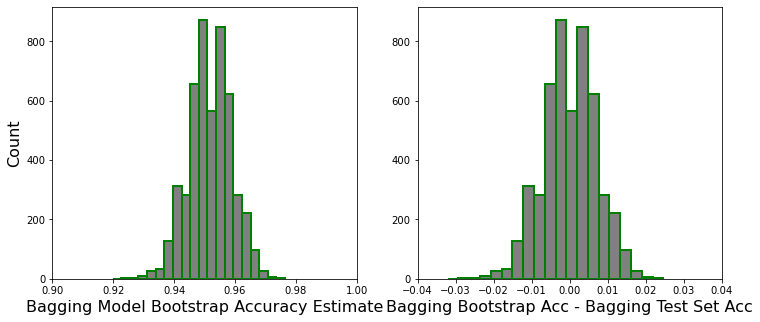

In [94]:
## Bagging Model Bootstrapping Graph
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bagging Model Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('Bagging Bootstrap Acc - Bagging Test Set Acc', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_bagging_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.90,1.00])
axs[1].hist(bs_bagging_output.iloc[:,0] - rf_lda_accuracy, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.04,0.04])

In [95]:
## Random Forest Model Bootstrapping
bs_rf_output = bootstrap_validation(x_test_lda, y_test_lda, y_train_lda, rf_lda_bv,
                                 metrics_list=[accuracy],
                                 sample = 5000)

(5000, 1)


(-0.03, 0.03)

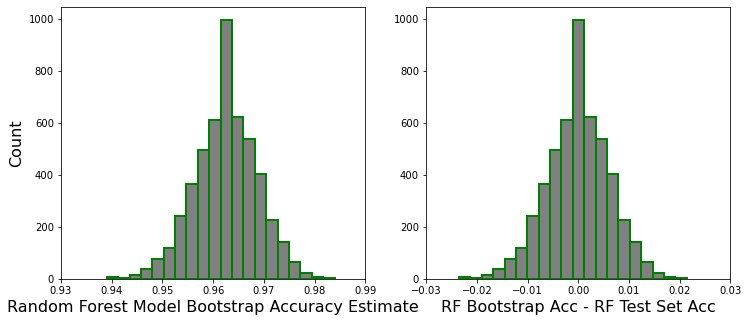

In [99]:
## Random Forest Model Bootstrapping Graph
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Random Forest Model Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('RF Bootstrap Acc - RF Test Set Acc', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_rf_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.93,0.99])
axs[1].hist(bs_rf_output.iloc[:,0] - rf_best_features_accuracy, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.03,0.03])

In [100]:
## Boosting Model Bootstrapping
bs_boosting_output = bootstrap_validation(x_test_lda, y_test_lda, y_train_lda, gbr,
                                 metrics_list=[accuracy],
                                 sample = 5000)

(5000, 1)


(-0.03, 0.02)

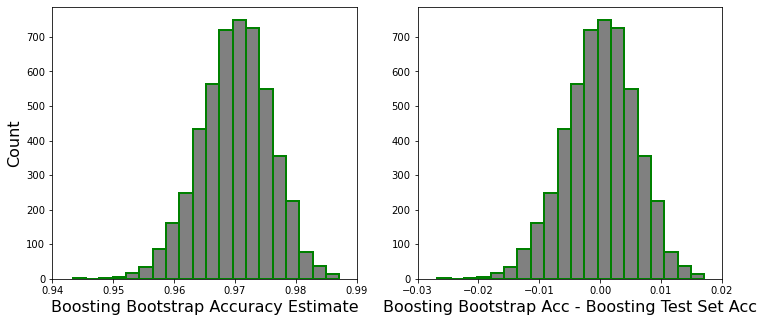

In [135]:
## Boosting Model Bootstrapping Graph
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Boosting Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('Boosting Bootstrap Acc - Boosting Test Set Acc', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_boosting_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.94,0.99])
axs[1].hist(bs_boosting_output.iloc[:,0] - gbr_accuracy, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.03,0.02])

In [133]:
var = '%'

CI_lda = np.quantile(bs_lda_output.iloc[:,0],np.array([0.025,0.975]))
CI_cart = np.quantile(bs_cart_output.iloc[:,0],np.array([0.025,0.975]))
CI_bagging = np.quantile(bs_bagging_output.iloc[:,0],np.array([0.025,0.975]))
CI_rf = np.quantile(bs_rf_output.iloc[:,0],np.array([0.025,0.975]))
CI_boosting = np.quantile(bs_boosting_output.iloc[:,0],np.array([0.025,0.975]))

print("LDA Model 95"+var,"Confidence Interval :", CI_lda)
print("CART Model 95"+var, "Confidence Interval :", CI_cart)
print("Bagging Model 95"+var, "Confidence Interval :", CI_bagging)
print("Random Forest Model 95"+var, "Confidence Interval :", CI_rf)
print("Boosting Model 95"+var, "Confidence Interval :", CI_boosting)

LDA Model 95% Confidence Interval : [0.8802139 0.9197861]
CART Model 95% Confidence Interval : [0.89839572 0.93368984]
Bagging Model 95% Confidence Interval : [0.93796791 0.9657754 ]
Random Forest Model 95% Confidence Interval : [0.94973262 0.97433155]
Boosting Model 95% Confidence Interval : [0.95828877 0.98074866]


In [139]:
boosting_lda = np.quantile(bs_boosting_output.iloc[:,0] - bs_lda_output.iloc[:,0], np.array([0.025,0.975]))
boosting_cart = np.quantile(bs_boosting_output.iloc[:,0] - bs_cart_output.iloc[:,0], np.array([0.025,0.975]))
boosting_bagging = np.quantile(bs_boosting_output.iloc[:,0] - bs_bagging_output.iloc[:,0], np.array([0.025,0.975]))
boosting_rf = np.quantile(bs_boosting_output.iloc[:,0] - bs_rf_output.iloc[:,0], np.array([0.025,0.975]))

print("(Boosting - LDA) 95"+var,"Confidence Interval :", boosting_lda)
print("(Boosting - CART)  95"+var, "Confidence Interval :", boosting_cart)
print("(Boosting - Bagging) 95"+var, "Confidence Interval :", boosting_bagging)
print("(Boosting - Random Forest) 95"+var, "Confidence Interval :", boosting_rf)


(Boosting - LDA) 95% Confidence Interval : [0.04705882 0.09197861]
(Boosting - CART)  95% Confidence Interval : [0.03315508 0.07486631]
(Boosting - Bagging) 95% Confidence Interval : [0.         0.03636364]
(Boosting - Random Forest) 95% Confidence Interval : [-0.00858289  0.02352941]
